In [1]:
import pandas as pd
df = pd.read_csv(r'C:\Users\Mouna\Desktop\Masters\Spring2019\Project Work\hurrican_irma1.csv',dtype='str',encoding='utf-8',error_bad_lines=False,keep_default_na=False)

In [3]:
df2 = pd.read_csv(r'C:\Users\Mouna\Desktop\Masters\Spring2019\Project Work\irma_coded_tweets.csv',dtype='str',encoding='utf-8',error_bad_lines=False,keep_default_na=False)

In [4]:
df3=df2[df2['irma_rel']=='1']

In [5]:
df_irma=pd.concat([df, df3])

In [6]:
df_irma.shape

(18296, 14)

In [7]:
df_irma.groupby('irma_rel').count()

,Unnamed: 0,enc_url,hashtags,location,timestamp,tweet,tweet_coords,tweet_coords_list,tweet_id,tweet_lang,tweet_lat,tweet_long,user_id
irma_rel,,,,,,,,,,,,,
0,10000,0,0,0,0,10000,0,0,0,0,0,0,0
1,8296,8296,8296,8296,8296,8296,8296,8296,8296,8296,8296,8296,8296


In [8]:
df_irma['t']=df_irma['tweet'].str.replace('http\S+|www.\S+', '', case=False)
df_irma['t'] = df_irma['t'].str.replace('@', ' ')
df_irma['t'] = df_irma['t'].str.replace('#', ' ')
df_irma['t']=df_irma['t'].str.lower()
from textblob import TextBlob
def split_into_lemmas(message):
    #message=message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]
df_irma['t']=df_irma['t'].apply(split_into_lemmas)

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stop = stopwords.words('english')
#stop.extend(['hurricaneirma','amp','irma','florida','hurrican','get'])
stop.extend(['amp','get'])
stemmer = SnowballStemmer("english")
df_irma['t'] = df_irma['t'].apply(lambda x: [stemmer.stem(y) for y in x])
df_irma['t']=df_irma['t'].apply(lambda x: [item for item in x if item not in stop])
df_irma['len']=df_irma['t'].str.len()
df_irma.drop(df_irma[df_irma['len']<=2].index,inplace=True)
tweets = df_irma['t'].tolist()
tweets = [[i for i in nested if len(i) > 2] for nested in tweets]

In [9]:
from gensim import corpora, models , similarities
import gensim


from gensim.test.utils import common_corpus, common_dictionary
from gensim.sklearn_api import TfIdfTransformer

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(tweets)

n_items = len(dictionary)

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in tweets]

C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
from gensim.models import LsiModel
lsi_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=200)

In [11]:
lsi_model.show_topics(num_topics=200)

[(0,
  '0.673*"irma" + 0.401*"florida" + 0.383*"hurrican" + 0.269*"hurricaneirma" + 0.125*"miami" + 0.118*"wind" + 0.097*"beach" + 0.094*"report" + 0.084*"gust" + 0.084*"rain"'),
 (1,
  '0.459*"report" + 0.422*"mph" + 0.409*"gust" + 0.396*"aso" + 0.384*"knot" + -0.198*"irma" + 0.128*"ese" + 0.111*"beach" + -0.087*"hurrican" + 0.079*"fort"'),
 (2,
  '-0.473*"wind" + -0.400*"rain" + 0.390*"irma" + -0.340*"hurricaneirma" + -0.294*"florida" + -0.242*"humid" + 0.204*"hurrican" + -0.139*"temperatur" + -0.132*"weather" + -0.125*"current"'),
 (3,
  '0.579*"florida" + -0.391*"wind" + 0.362*"hurricaneirma" + -0.323*"rain" + -0.293*"irma" + -0.206*"humid" + -0.166*"hurrican" + -0.120*"temperatur" + -0.102*"weather" + 0.100*"counti"'),
 (4,
  '0.664*"hurricaneirma" + -0.509*"florida" + 0.410*"hurrican" + -0.233*"irma" + 0.079*"power" + -0.078*"counti" + 0.065*"storm" + -0.063*"rain" + -0.058*"humid" + 0.055*"report"'),
 (5,
  '0.744*"hurrican" + -0.426*"irma" + -0.377*"hurricaneirma" + 0.285*"flor

In [31]:
lda_vectors=[]
for i in range(len(corpus)):
    top_topics=lsi_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(150)]
    lda_vectors.append(topic_vec)
    
    
import numpy as np
y=np.array(df_irma.irma_rel)
X=np.array(lda_vectors)
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                random_state=2,test_size=0.2)
print(Xtrain.shape, Xtest.shape)

from xgboost import XGBClassifier
trained_model = XGBClassifier(n_estimators=300, learning_rate=0.3)
trained_model.fit(Xtrain,ytrain)
predictions = trained_model.predict(Xtest)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print ("\n Confusion matrix \n", confusion_matrix(ytest, predictions))
print("\nClassification Report :: \n", classification_report(ytest, predictions))
print("Accuracy",accuracy_score(ytest, predictions))

AttributeError: 'LsiModel' object has no attribute 'get_document_topics'

In [12]:
import numpy as np
lda_lambda = lsi_model.state.get_lambda()
lda_lambda = lda_lambda / lda_lambda.sum(axis=1)[:, np.newaxis] # normalize vector
print(lda_lambda)

AttributeError: 'LsiModel' object has no attribute 'state'

In [26]:
from gensim.models import HdpModel
lda_model = HdpModel(corpus=corpus, id2word=dictionary)

In [35]:
lsi_model.get_topics(0)

TypeError: get_topics() takes 1 positional argument but 2 were given

In [15]:
import itertools as itt
edges = [(i, j, {'weight': gensim.matutils.hellinger(lda_lambda[i], lda_lambda[j])})
         for i, j in itt.combinations(range(lda_model.num_topics), 2)]

In [36]:
edges

[(0, 1, {'weight': 0.76368100680381801}),
 (0, 2, {'weight': 0.73088229299931751}),
 (0, 3, {'weight': 0.72673049133172474}),
 (0, 4, {'weight': 0.75080589865276248}),
 (0, 5, {'weight': 0.74749014034594341}),
 (0, 6, {'weight': 0.7230807320670839}),
 (0, 7, {'weight': 0.73304551086331382}),
 (0, 8, {'weight': 0.74189274606794975}),
 (0, 9, {'weight': 0.72384891552204556}),
 (0, 10, {'weight': 0.74583618351766467}),
 (0, 11, {'weight': 0.75626380214233846}),
 (0, 12, {'weight': 0.75378065100704927}),
 (0, 13, {'weight': 0.72748498907693993}),
 (0, 14, {'weight': 0.71871579130283503}),
 (0, 15, {'weight': 0.74614303985275865}),
 (0, 16, {'weight': 0.7643598106790247}),
 (0, 17, {'weight': 0.75709342268199298}),
 (0, 18, {'weight': 0.72016055144939151}),
 (0, 19, {'weight': 0.74737722039168031}),
 (0, 20, {'weight': 0.71662626392859219}),
 (0, 21, {'weight': 0.74726360538127989}),
 (0, 22, {'weight': 0.74023248274669506}),
 (0, 23, {'weight': 0.73357867630654661}),
 (0, 24, {'weight': 0.

0.748209461037


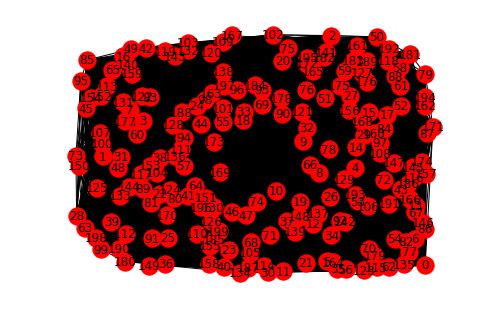

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_nodes_from(range(lda_model.num_topics))
k = np.percentile(np.array([e[2]['weight'] for e in edges]), 80)
print(k)
#G.add_edges_from(edges)
pos=nx.spring_layout(G,k=0.9,iterations=1)  
G.add_edges_from([e for e in edges if e[2]['weight'] < k])
nx.draw(G,pos,with_labels=True)

fig=plt.figure()
plt.figure(figsize=(50,50))
plt.show()

In [17]:
from community import community_louvain
parts = community_louvain.best_partition(G)
values = [parts.get(node) for node in G.nodes()]

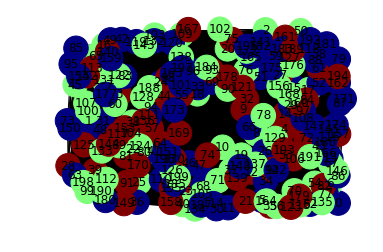

In [18]:
plt.axis("off")
nx.draw_networkx(G, pos =pos, cmap = plt.get_cmap("jet"), node_color = values,node_size = 600, with_labels = True)
plt.show()

In [19]:
set(values)

{0, 1, 2}

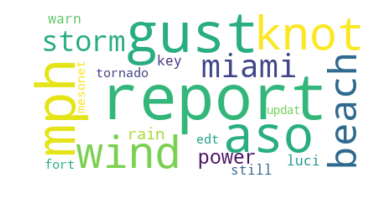

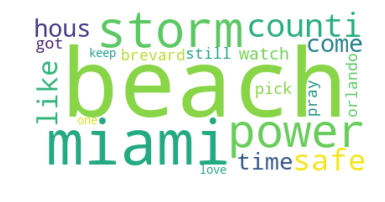

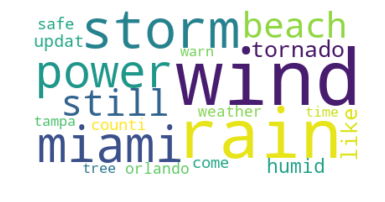

In [41]:
import itertools
import operator
from wordcloud import WordCloud

list0=[index for index, value in enumerate(values) if value == 0]
list1=[index for index, value in enumerate(values) if value == 1]
list2=[index for index, value in enumerate(values) if value == 2]

value0_topics=[]
for i in list0:
    value0_topics.extend(lda_model.show_topic(i))   
value1_topics=[]
for i in list1:
    value1_topics.extend(lda_model.show_topic(i)) 
value2_topics=[]
for i in list2:
    value2_topics.extend(lda_model.show_topic(i))

    
value2_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value2_topics, key = lambda i: i[0]), lambda i: i[0])]
value1_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value1_topics, key = lambda i: i[0]), lambda i: i[0])]
value0_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value0_topics, key = lambda i: i[0]), lambda i: i[0])]

value2_topics.sort(key = operator.itemgetter(1),reverse=True)
value1_topics.sort(key = operator.itemgetter(1),reverse=True)
value0_topics.sort(key = operator.itemgetter(1),reverse=True)

wordcloud0 = WordCloud(background_color="white").fit_words(dict(value0_topics[:20]))
plt.figure()
plt.imshow(wordcloud0, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud1 = WordCloud(background_color="white").fit_words(dict(value1_topics[:20]))
plt.figure()
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud2 = WordCloud(background_color="white").fit_words(dict(value2_topics[:20]))
plt.figure()
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

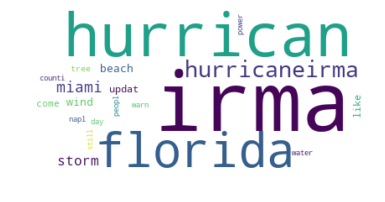

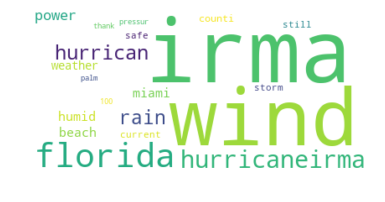

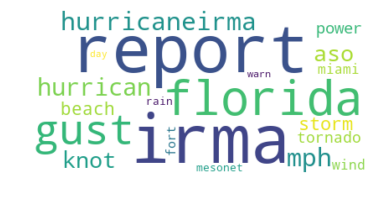

In [20]:
import itertools
import operator
from wordcloud import WordCloud

list0=[index for index, value in enumerate(values) if value == 0]
list1=[index for index, value in enumerate(values) if value == 1]
list2=[index for index, value in enumerate(values) if value == 2]
#list3=[index for index, value in enumerate(values) if value == 3]
#list4=[index for index, value in enumerate(values) if value == 4]

value0_topics=[]
for i in list0:
    value0_topics.extend(lda_model.show_topic(i))   
value1_topics=[]
for i in list1:
    value1_topics.extend(lda_model.show_topic(i)) 
value2_topics=[]
for i in list2:
    value2_topics.extend(lda_model.show_topic(i))
value3_topics=[]
#for i in list3:
 #   value3_topics.extend(lda_model.show_topic(i))
value4_topics=[]
#for i in list3:
 #value4_topics.extend(lda_model.show_topic(i))

#value4_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value4_topics, key = lambda i: i[0]), lambda i: i[0])]    
#value3_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value3_topics, key = lambda i: i[0]), lambda i: i[0])]    
value2_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value2_topics, key = lambda i: i[0]), lambda i: i[0])]
value1_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value1_topics, key = lambda i: i[0]), lambda i: i[0])]
value0_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value0_topics, key = lambda i: i[0]), lambda i: i[0])]

#value4_topics.sort(key = operator.itemgetter(1),reverse=True)
#value3_topics.sort(key = operator.itemgetter(1),reverse=True)
value2_topics.sort(key = operator.itemgetter(1),reverse=True)
value1_topics.sort(key = operator.itemgetter(1),reverse=True)
value0_topics.sort(key = operator.itemgetter(1),reverse=True)

wordcloud0 = WordCloud(background_color="white").fit_words(dict(value0_topics[:20]))
plt.figure()
plt.imshow(wordcloud0, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud1 = WordCloud(background_color="white").fit_words(dict(value1_topics[:20]))
plt.figure()
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud2 = WordCloud(background_color="white").fit_words(dict(value2_topics[:20]))
plt.figure()
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()


In [42]:
tweets

[['donotnut',
  'cashnastygam',
  '50kalmal',
  'jesserthelaz',
  'zackttgam',
  'got',
  'jesser',
  'ttg',
  'take',
  'serious',
  'issa'],
 ['julia_gulia_1', 'spectresghost', 'done'],
 ['delduquerafaela', 'bjo', 'nessa', 'boca', 'sua', 'ridicula'],
 ['current',
  'weather',
  'kendal',
  'light',
  'rain',
  '100',
  'humid',
  'wind',
  '43mph',
  'pressur',
  '992mb'],
 ['ritualist',
  'woman',
  'grew',
  'father',
  'practic',
  'umbanda',
  'back',
  'brasil'],
 ['burgerstationfl', 'hernando'],
 ['great',
  'see',
  'dtjax',
  'ramjacksonvill',
  'morn',
  'promot',
  'oktoberfest',
  'artwalkjax',
  'come',
  'visit',
  'see'],
 ['3lectric5heep',
  'fraud',
  'lsarsour',
  'muslim',
  'supremacist',
  'tri',
  'sedit',
  'terror',
  'hate',
  'violenc',
  'democrat',
  'doyenn'],
 ['cashier', 'point', 'lmao'],
 ['left', 'mom', 'tbh'],
 ['coloni', 'store', 'perfect', 'weekend', 'essenti', 'got', 'retro'],
 ['at/on',
  'happi',
  'place',
  'favorit',
  'peep',
  'noth',
  'bet